# Predicting Appointment No Shows  with Amazon SageMaker XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem**_

---

---

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Exentsions](#Extensions)

---

## Background


This notebook uses XGBoost to predict whether a patient will be a no-show for a medical appointment.The dataset was downloaded from Kaggle https://www.kaggle.com/joniarroba/noshowappointments. The appointment data of 110,527 records was collected from medical clinics in the city of Vitoria, Brazil, over a three month period in 2016.

The following steps were undertaken:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Preparation

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

## Notes
The first model uses age and waiting time as continuous features. However, the model performs poorly as the recall is very low.

In [ ]:
bucket = 'sagemaker-sf-strategenics'
prefix = 'sagemaker/DEMO-xgboost-noShow'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Bring in the Python libraries that we'll use throughout the analysis

In [ ]:
from datetime import date
from datetime import time
from datetime import datetime
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference
import seaborn as sns

---

## Data
The csv file containing the data is stored in an S3 bucket. First let's read the data file into a Pandas data frame.

In [3]:
data_key = 'appointmentData.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

noShow= pd.read_csv(data_location)

pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
noShow
noShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Let's start by renaming some of the columns

In [4]:
noShow.rename(columns = {'Hipertension': 'Hypertension',
                         'Handcap': 'Disabilities'}, inplace = True)

print(noShow.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Disabilities', 'SMS_received', 'No-show'],
      dtype='object')


As we have the date that the appointment was scheduled and the date of the appointment, we can calculate the number of days that the patient waited for the appointment.

First we have to convert the two date columns to a date format.

In [5]:
#convert date columns to a date format
noShow['tempSchedDate'] = pd.to_datetime(noShow['ScheduledDay'])
noShow['tempAppDate'] = pd.to_datetime(noShow['AppointmentDay'])
#get the date part of the date columns, as the Scheduled date has a time component but the appointment day does not
noShow['AppointmentDate']= noShow['tempAppDate'].dt.date
noShow['AppointmentBooked']= noShow['tempSchedDate'].dt.date
#calculate the waiting time
noShow['WaitingTime'] = (noShow.AppointmentDate - noShow.AppointmentBooked).dt.days

print(noShow.AppointmentBooked.head())
print(noShow.AppointmentDate.head())
print(noShow.WaitingTime.head())
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page


0    2016-04-29
1    2016-04-29
2    2016-04-29
3    2016-04-29
4    2016-04-29
Name: AppointmentBooked, dtype: object
0    2016-04-29
1    2016-04-29
2    2016-04-29
3    2016-04-29
4    2016-04-29
Name: AppointmentDate, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: WaitingTime, dtype: int64


Calculate the day of the week for the appointment day and drop the original scheduled and appointment columns.

In [6]:
#Find the day of the week of the appointment
noShow['DayOfWeek'] = noShow['tempAppDate'].dt.day_name()

#drop the columns no longer needed
noShow = noShow.drop(['ScheduledDay','AppointmentDay','tempSchedDate','tempAppDate'], axis=1)

print(noShow.AppointmentDate.head())
print(noShow.DayOfWeek.head())
print('Day of week:', sorted(noShow.DayOfWeek.unique()))

0    2016-04-29
1    2016-04-29
2    2016-04-29
3    2016-04-29
4    2016-04-29
Name: AppointmentDate, dtype: object
0    Friday
1    Friday
2    Friday
3    Friday
4    Friday
Name: DayOfWeek, dtype: object
Day of week: ['Friday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday']


Check that we don't have any duplicate data by looking at the appointmentID which should be unique.

In [ ]:
print('Total appointments: ' + format(noShow.shape[0], ",d"))
print('Unique appointments: ' + format(noShow['AppointmentID'].unique().shape[0], ",d"))

    There are no duplicate Appointment IDs so we will index the data by AppointmentID. We also need to convert PatientId to an integer.

In [7]:
noShow.PatientId = noShow.PatientId.astype('int64')
print(noShow.PatientId.head())
noShow.set_index('AppointmentID', inplace = True)

0     29872499824296
1    558997776694438
2      4262962299951
3       867951213174
4      8841186448183
Name: PatientId, dtype: int64


In [ ]:
noShow
noShow.info()

### Exploration
Let's start exploring the data.  First, let's understand how the features are distributed.

In [ ]:
# Frequency tables for each categorical feature
for column in noShow.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=noShow[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(noShow.describe())
%matplotlib inline
hist = noShow.hist(bins=30, figsize=(10, 10))

print('Age:', sorted(noShow.Age.unique()))
print('Waiting time:', sorted(noShow.WaitingTime.unique()))



# Data Summary

* There are 110,527 patient records, and 13 features for each patient
* The features are mixed; some numeric, some categorical


*Features:*
* `Age`: Patient's age. Integer -1 to 115
* `Gender`: Patient's gender, string M,F
* `Alcoholism`: Binary, 1=yes
* `Diabetes`:Binary, 1= yes
* `Hypertension`:Binary, 1= yes
* `Disabilities`: The number of disabilities for a patient. Integer, 1-4
* `Scholarship`: This indicates whether the patient receives financial support from the government. Binary, 1=yes
* `Neighbourhood`: This is the location of the medical clinic. String, 80 values
* `SMS_receceived`:Whether they received a SMS reminder before the appointment. Binary, 1= yes
* `AppointmentBooked`: Date that the appointment was booked
* `AppointmentDate`: Date of the appointment
* `DayOfWeek`: The weekday of the appointment. Integer, 0-5
* `WaitingTime`: The number of days between booking the appointment and the appointment date. Integer, -6 to 179


*Target variable:*
* `No-show`: Was the patient a no-show? Binary: 1=yes,0=no
Overall, 20% of the patients were no-shows.

In [8]:
noShow['Age'] = np.where(noShow['Age']<0, np.nan, noShow['Age'])
noShow['Age'].describe()
noShow['WaitingTime'] = np.where(noShow['WaitingTime']<0, np.nan, noShow['WaitingTime'])
noShow['WaitingTime'].describe()

count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: WaitingTime, dtype: float64

Disability has values from 0-5, indicating the number of disabilities a patient has. We will turn this into a binary column to indicate whether the patient has a disablity or not.

In [9]:
noShow['Disability'] = np.where(noShow['Disabilities']>1, 1, noShow['Disabilities'])
print('Disability:', sorted(noShow.Disability.unique()))
count = noShow.groupby(['Disability', 'Disabilities']).size() 
print(count)  


Disability: [0, 1]
Disability  Disabilities
0           0               108286
1           1                 2042
            2                  183
            3                   13
            4                    3
dtype: int64


In [ ]:
Now we will look at patient history as it is possible that people who have a previous no-show are more likely to no-show again.

In [10]:
#determine if a patient has had a previous appointment
noShow.sort_values(by=['PatientId','AppointmentDate'], inplace=True)
pd.options.display.max_rows=100
noShow['PreviousAppointment'] = noShow.sort_values(by = ['PatientId','AppointmentDate']).groupby(['PatientId']).cumcount()
#print(noShow[['PatientId','AppointmentDate', 'PreviousAppointment']].head(100)) 


a = noShow.groupby(pd.cut(noShow.PreviousAppointment, bins = [-1, 0,1,2,3,4,5, 85], include_lowest = True))[['PreviousAppointment']].count()
b = pd.DataFrame(a)
b.set_index(pd.Series(['0', '1', '2', '3', '4', '5', '> 5']))

,PreviousAppointment
0,62299
1,24379
2,10484
3,4984
4,2617
5,1498
> 5,4264


In [ ]:
Calculate whether the patient has a previous no-show

In [11]:
noShow['NoShow']=np.where(noShow['No-show'] == "Yes", 1,0)
count = noShow.groupby(['No-show', 'NoShow']).size() 
print(count)

#noShow['PreviousNoShow'] = (noShow[noShow['PreviousAppointment'] > 0].sort_values(['PatientId', 'AppointmentDate']).groupby(['PatientId'])['NoShow'].cumsum())
noShow['NumberOfPreviousNoShow'] = (noShow.sort_values(['PatientId', 'AppointmentDate']).groupby(['PatientId'])['NoShow'].cumsum())
noShow['PreviousNoShows']=noShow['NumberOfPreviousNoShow']-noShow['NoShow']


def history(x):
    if x['PreviousAppointment'] == 0 : return 'First appointment'
    elif x['PreviousAppointment'] > 0 and x['PreviousNoShows'] == 0: return 'No previous no-shows'
    else: return 'At least one previous no-show'
    

noShow['PatientHistory'] = noShow.apply(history,axis=1)

pd.options.display.max_rows=100
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
noShow.sort_values(by=['PatientId','AppointmentDate'], inplace=True)
#print(noShow[['PatientId','AppointmentDate', 'No-show', 'PreviousAppointment','PreviousNoShows','PatientHistory']].head(100)) 

 
count = noShow.groupby(['PatientHistory']).size() 
print(count)

No-show  NoShow
No       0         88208
Yes      1         22319
dtype: int64
PatientHistory
At least one previous no-show    15624
First appointment                62299
No previous no-shows             32604
dtype: int64



Now let's look at how our features relate to the probability of not turning up to the appointment.

In [12]:
#drop columns that we no longer need
noShow = noShow.drop(['NoShow','AppointmentDate','AppointmentBooked','PreviousNoShows','NumberOfPreviousNoShow','PreviousAppointment'], axis=1)
noShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5751990 to 5660958
Data columns (total 15 columns):
PatientId         110527 non-null int64
Gender            110527 non-null object
Age               110526 non-null float64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Disabilities      110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
WaitingTime       110522 non-null float64
DayOfWeek         110527 non-null object
Disability        110527 non-null int64
PatientHistory    110527 non-null object
dtypes: float64(2), int64(8), object(5)
memory usage: 13.5+ MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5751990 to 5660958
Data columns (total 17 columns):
PatientId         110527 non-null int64
Gender            110527 non-null object
Age               110526 non-null float64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Disabilities      110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null category
WaitingTime       110522 non-null float64
DayOfWeek         110527 non-null object
Disability        110527 non-null int64
PatientHistory    110527 non-null object
Attended          110527 non-null uint8
NoShow            110527 non-null uint8
dtypes: category(1), float64(2), int64(8), object(4), uint8(2)
memory usage: 13.0+ MB


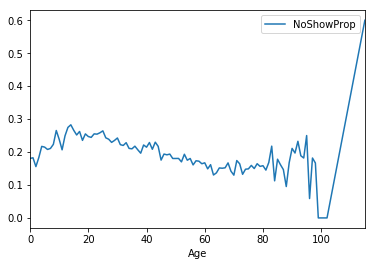

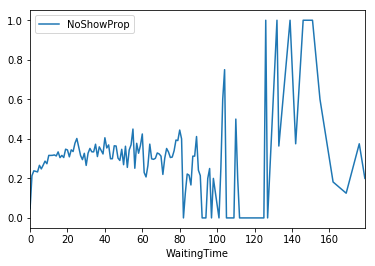

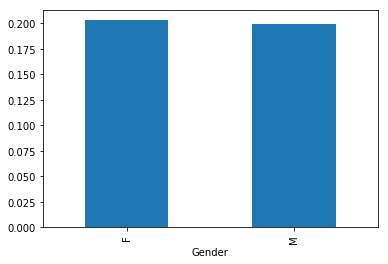

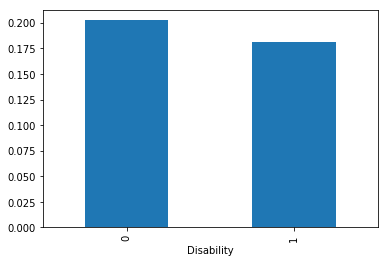

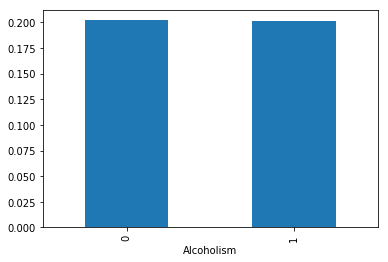

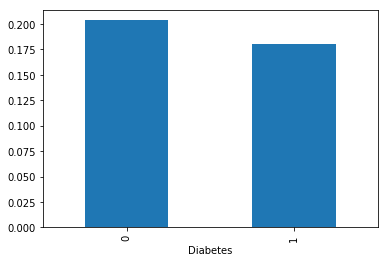

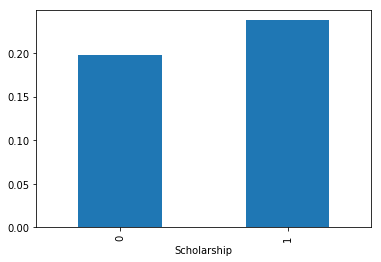

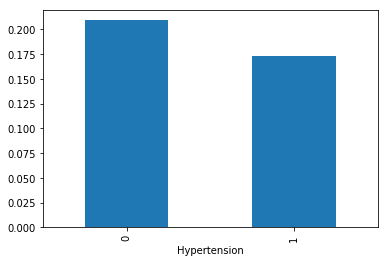

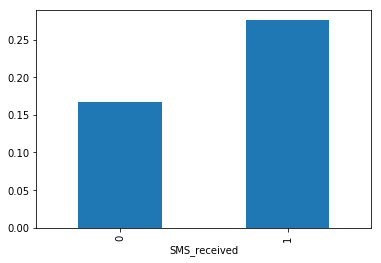

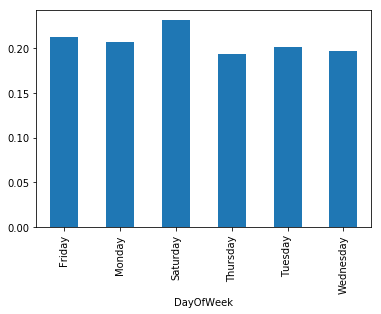

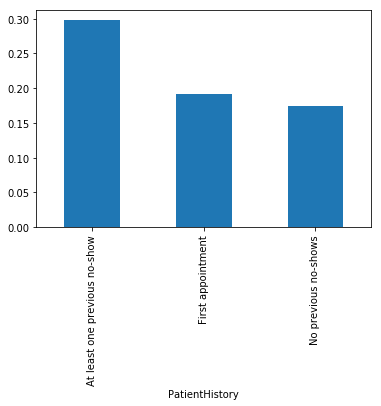

In [13]:
#create dummy variables for no-show so that we can calculate the probability of being a no-show


noShow['No-show'] = noShow['No-show'].astype('category')
noShow = noShow.join(pd.get_dummies(noShow['No-show']))


noShow.rename(columns = {'No': 'Attended',
                         'Yes': 'NoShow'}, inplace = True)
noShow.info()

df2 = noShow.groupby('Age').sum()
df2['NoShowProp'] = df2['NoShow'] / (df2['Attended'] + df2['NoShow'])
df2[['NoShowProp']].plot()

df2 = noShow.groupby('WaitingTime').sum()
df2['NoShowProp'] = df2['NoShow'] / (df2['Attended'] + df2['NoShow'])
df2[['NoShowProp']].plot()

def plotNoShow(var):
 df2 = noShow.groupby([var])['Attended','NoShow'].sum()
 df2['NoShowProp'] = df2['NoShow'] / (df2['Attended'] + df2['NoShow'])
 df2[['NoShowProp']].plot(kind='bar',stacked=True,legend=False)
 df2

    
plotNoShow('Gender')    
plotNoShow('Disability')
plotNoShow('Alcoholism')
plotNoShow('Diabetes')
plotNoShow('Scholarship')
plotNoShow('Hypertension')
plotNoShow('SMS_received')
plotNoShow('DayOfWeek')
plotNoShow('PatientHistory')


In [ ]:
Now have a look at interactions


In [ ]:
def plotInt(var,var2):
 df2 = noShow.groupby([var,var2])['Attended','NoShow'].sum()
 df2['NoShowProp'] = df2['NoShow'] / (df2['Attended'] + df2['NoShow'])
 print(df2)
 #df2[['NoShowProp']].plot(kind='bar',stacked=True,legend=False)
 df2

plotInt('Diabetes','Alcoholism')
plotInt('Diabetes','Disability')
plotInt('Diabetes','Gender')
plotInt('Diabetes','Hypertension')
plotInt('Diabetes','Scholarship')
plotInt('Diabetes','SMS_received')
plotInt('Diabetes','DayOfWeek')
plotInt('Diabetes','PatientHistory')


plotInt('Alcoholism','Disability')
plotInt('Alcoholism','Gender')
plotInt('Alcoholism','Hypertension')
plotInt('Alcoholism','Scholarship')
plotInt('Alcoholism','SMS_received')
plotInt('Alcoholism','DayOfWeek')
plotInt('Alcoholism','PatientHistory')


plotInt('Disability','Gender')
plotInt('Disability','Hypertension')
plotInt('Disability','Scholarship')
plotInt('Disability','SMS_received')
plotInt('Disability','DayOfWeek')
plotInt('Disability','PatientHistory')





In [ ]:
#check for correlation between age and waiting time
plt.scatter(noShow.Age, noShow.WaitingTime, c=noShow.NoShow)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Waiting Time", fontsize=12)
plt.legend()

There seems to be some evidence of interaction between the variables, so we will keep all columns in the model. For the first model we will drop neighbourhood as there are more than 80 different values and a lot of sparsity. Would be interesting to add back in later to see how XGBoost handles it.

In [14]:
#drop PatientID, AppointmentID and Neightbourhood - check whether we can drop and index column
#noShow = noShow.drop(['PatientID','Neighbourhood','AppointmentID'], axis=1)

noShowFinal = noShow[['No-show', 'Gender', 'Age','Scholarship','Hypertension','Diabetes','Alcoholism','Disability','SMS_received','WaitingTime','DayOfWeek','PatientHistory']].copy()
noShowFinal.info()
#create indicator columns for categorical columns, as requried by XGBoost
model_data = pd.get_dummies(noShowFinal) 
model_data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5751990 to 5660958
Data columns (total 12 columns):
No-show           110527 non-null category
Gender            110527 non-null object
Age               110526 non-null float64
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Disability        110527 non-null int64
SMS_received      110527 non-null int64
WaitingTime       110522 non-null float64
DayOfWeek         110527 non-null object
PatientHistory    110527 non-null object
dtypes: category(1), float64(2), int64(6), object(3)
memory usage: 10.2+ MB


,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,WaitingTime,No-show_No,No-show_Yes,Gender_F,Gender_M,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PatientHistory_At least one previous no-show,PatientHistory_First appointment,PatientHistory_No previous no-shows
AppointmentID,,,,,,,,,,,,,,,,,,,,,
5751990,44.0,0,0,0,0,0,0,3.0,1,0,1,0,1,0,0,0,0,0,0,1,0
5760144,39.0,0,0,1,0,0,0,0.0,1,0,0,1,0,0,0,0,0,1,0,1,0
5712759,33.0,0,0,0,0,0,0,0.0,1,0,1,0,0,0,0,0,0,1,0,1,0
5637648,12.0,0,0,0,0,0,0,3.0,1,0,0,1,0,1,0,0,0,0,0,1,0
5637728,14.0,0,0,0,0,0,1,7.0,1,0,1,0,1,0,0,0,0,0,0,1,0


Split the dataset into training data (70%), validation data (20%) and prediction data (10%)

In [15]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=8147), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%


In [16]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)
train_data.info()

(77368, 21)
(22106, 21)
(11053, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77368 entries, 5664524 to 5716188
Data columns (total 21 columns):
Age                                             77367 non-null float64
Scholarship                                     77368 non-null int64
Hypertension                                    77368 non-null int64
Diabetes                                        77368 non-null int64
Alcoholism                                      77368 non-null int64
Disability                                      77368 non-null int64
SMS_received                                    77368 non-null int64
WaitingTime                                     77366 non-null float64
No-show_No                                      77368 non-null uint8
No-show_Yes                                     77368 non-null uint8
Gender_F                                        77368 non-null uint8
Gender_M                                        77368 non-null uint8
DayOfWeek_Frida

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [17]:
pd.concat([train_data['No-show_Yes'], train_data.drop(['No-show_No', 'No-show_Yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['No-show_Yes'], validation_data.drop(['No-show_No', 'No-show_Yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [18]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---

## Training
Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make gradient boosted trees a good candidate algorithm.

There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models.  Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

`xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [19]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-1')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [20]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. Algorithm hyperparameters

And then a `.fit()` function which specifies:
1. S3 location for output data.  In this case we have both a training and validation set which are passed in.

In [22]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=7,
                        eta=0.4,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100,
                        eval_metric='accuracy')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-11-12 02:12:40 Starting - Starting the training job...
2019-11-12 02:12:45 Starting - Launching requested ML instances......
2019-11-12 02:13:47 Starting - Preparing the instances for training......
2019-11-12 02:15:06 Downloading - Downloading input data
2019-11-12 02:15:06 Training - Downloading the training image...
2019-11-12 02:15:28 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value accuracy to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','

[66]#011train-error:0.19172#011validation-error:0.19497#011train-accuracy:0.80828#011validation-accuracy:0.80503
[67]#011train-error:0.19163#011validation-error:0.195422#011train-accuracy:0.80837#011validation-accuracy:0.804578
[68]#011train-error:0.191475#011validation-error:0.195603#011train-accuracy:0.808525#011validation-accuracy:0.804397
[69]#011train-error:0.191371#011validation-error:0.19601#011train-accuracy:0.808629#011validation-accuracy:0.80399
[70]#011train-error:0.191255#011validation-error:0.195648#011train-accuracy:0.808745#011validation-accuracy:0.804352
[71]#011train-error:0.191164#011validation-error:0.195422#011train-accuracy:0.808836#011validation-accuracy:0.804578
[72]#011train-error:0.191113#011validation-error:0.195332#011train-accuracy:0.808887#011validation-accuracy:0.804668
[73]#011train-error:0.191126#011validation-error:0.195286#011train-accuracy:0.808874#011validation-accuracy:0.804714
[74]#011train-error:0.1911#011validation-error:0.195241#011train-accurac

In [ ]:
#!conda install -y -c conda-forge xgboost 

In [23]:
          
import tarfile
import pickle as pkl
import xgboost

# download the model artifact from AWS S3
!aws s3 cp s3://sagemaker-sf-strategenics/sagemaker/DEMO-xgboost-noShow/output/sagemaker-xgboost-2019-11-12-02-12-40-195/output/model.tar.gz .

#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))            

download: s3://sagemaker-sf-strategenics/sagemaker/DEMO-xgboost-noShow/output/sagemaker-xgboost-2019-11-12-02-12-40-195/output/model.tar.gz to ./model.tar.gz


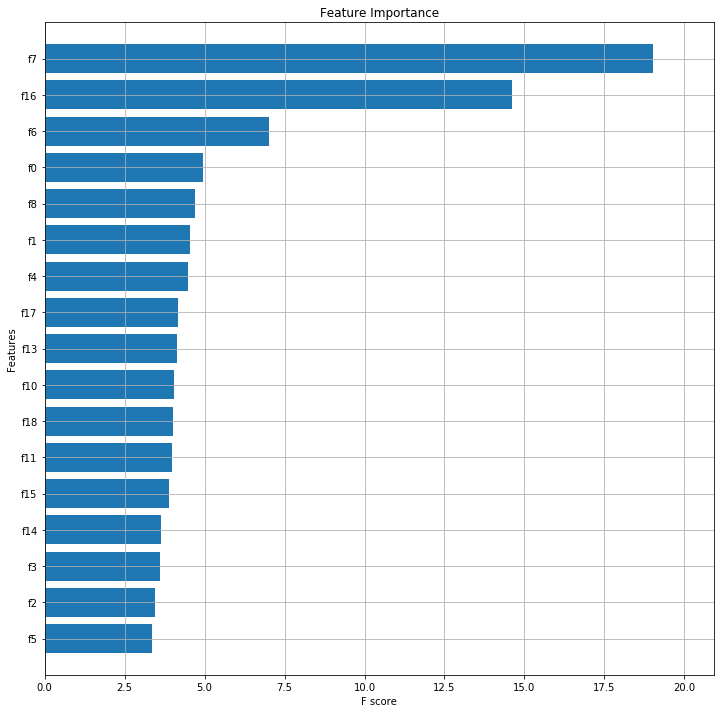

In [24]:
#map_names = dict(zip(model.feature_names, train_data[cols_input].columns))
#model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77368 entries, 5664524 to 5716188
Data columns (total 21 columns):
Age                                             77367 non-null float64
Scholarship                                     77368 non-null int64
Hypertension                                    77368 non-null int64
Diabetes                                        77368 non-null int64
Alcoholism                                      77368 non-null int64
Disability                                      77368 non-null int64
SMS_received                                    77368 non-null int64
WaitingTime                                     77366 non-null float64
No-show_No                                      77368 non-null uint8
No-show_Yes                                     77368 non-null uint8
Gender_F                                        77368 non-null uint8
Gender_M                                        77368 non-null uint8
DayOfWeek_Friday                                773

---

## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [26]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

-------------------------------------------------------------------------------------------------------------!

---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.  In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`), which produces a simple confusion matrix.

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [27]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [28]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')
test_data.describe()
predictions = predict(test_data.drop(['No-show_No', 'No-show_Yes'], axis=1).as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [29]:
pd.crosstab(index=test_data['No-show_Yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'],margins=True)

predictions,0.0,1.0,All
actuals,,,
0,8593,183,8776
1,2100,177,2277
All,10693,360,11053


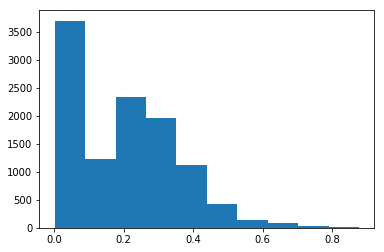

predictions,0,1,All
actuals,,,
0,6989,1787,8776
1,1187,1090,2277
All,8176,2877,11053


In [42]:
plt.hist(predictions)
plt.show()
predictions
pd.crosstab(index=test_data['No-show_Yes'], columns=np.where(predictions > 0.3, 1, 0), rownames=['actuals'], colnames=['predictions'],margins=True)

In summary, of the 11053 patients, we predicted 514 would subscribe and 2277 of them actually did.  We also had 2,013 that were no-shows but we predicted as turning up.  This is less than desirable, but the model can (and should) be tuned to improve this.  


### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [43]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)